Image-Based Predictive Model for Optimal Washing and Drying Methods
Jeihan Ivan Hadar 

In [1]:
# Importing the necessary libraries for the ML and DL model development 
# And for data manipulation, analyzing data, numerical operations 
# And image processing, data splitting and etc. 
import os
import pandas as pd
import numpy as np
from PIL import Image
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Loading the CSV file into a DataFrame
df = pd.read_csv('labels.csv')

# Defining the dataset directory
dataset_directory = 'image_aug'

In [4]:
df.head()

,image_file,Hand wash,Laundry,Dry clean,Air dry,Tumble dry,Flat dry
0,acrylic_hat_867.jpeg,1,0,0,1,0,1
1,acrylic_hat_1382.jpeg,1,0,0,1,0,1
2,acrylic_hat_164.jpeg,1,0,0,1,0,1
3,acrylic_hat_1228.jpeg,1,0,0,1,0,1
4,acrylic_hat_534.jpeg,1,0,0,1,0,1


In [ ]:
# Making a function to concatenate the colomn names (cleaning methods) that 
# has the corresponding value of '1' into a string
def concatenate_columns(row):
    return ', '.join(row.index[row == 1])

# Applying the function above to each and every row of the dataset
df['Combined'] = df.apply(concatenate_columns, axis=1)

df.head() 

,image_file,Hand wash,Laundry,Dry clean,Air dry,Tumble dry,Flat dry,Combined
0,acrylic_hat_867.jpeg,1,0,0,1,0,1,"Hand wash, Air dry, Flat dry"
1,acrylic_hat_1382.jpeg,1,0,0,1,0,1,"Hand wash, Air dry, Flat dry"
2,acrylic_hat_164.jpeg,1,0,0,1,0,1,"Hand wash, Air dry, Flat dry"
3,acrylic_hat_1228.jpeg,1,0,0,1,0,1,"Hand wash, Air dry, Flat dry"
4,acrylic_hat_534.jpeg,1,0,0,1,0,1,"Hand wash, Air dry, Flat dry"


In [6]:
df.tail()

,image_file,Hand wash,Laundry,Dry clean,Air dry,Tumble dry,Flat dry,Combined
19794,wool_sweater_1023.jpeg,1,0,1,1,0,1,"Hand wash, Dry clean, Air dry, Flat dry"
19795,wool_sweater_1536.jpeg,1,0,1,1,0,1,"Hand wash, Dry clean, Air dry, Flat dry"
19796,wool_sweater_597.jpeg,1,0,1,1,0,1,"Hand wash, Dry clean, Air dry, Flat dry"
19797,wool_sweater_1166.jpeg,1,0,1,1,0,1,"Hand wash, Dry clean, Air dry, Flat dry"
19798,wool_sweater_1865.jpeg,1,0,1,1,0,1,"Hand wash, Dry clean, Air dry, Flat dry"


In [7]:
# Only using these labels for the dataset
df = df[['image_file', 'Combined']] 

In [8]:
df.head()

,image_file,Combined
0,acrylic_hat_867.jpeg,"Hand wash, Air dry, Flat dry"
1,acrylic_hat_1382.jpeg,"Hand wash, Air dry, Flat dry"
2,acrylic_hat_164.jpeg,"Hand wash, Air dry, Flat dry"
3,acrylic_hat_1228.jpeg,"Hand wash, Air dry, Flat dry"
4,acrylic_hat_534.jpeg,"Hand wash, Air dry, Flat dry"


In [9]:
# count how many values for each class
df['Combined'].value_counts() 

Hand wash, Dry clean, Air dry, Flat dry    6746
Laundry, Air dry, Tumble dry               5540
Hand wash, Laundry, Air dry, Flat dry      3743
Dry clean                                  2112
Hand wash, Air dry, Flat dry               1658
Name: Combined, dtype: int64

<ipython-input-13-b3037c62f7e7>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=value_plot.values, y=value_plot.index, palette='viridis')


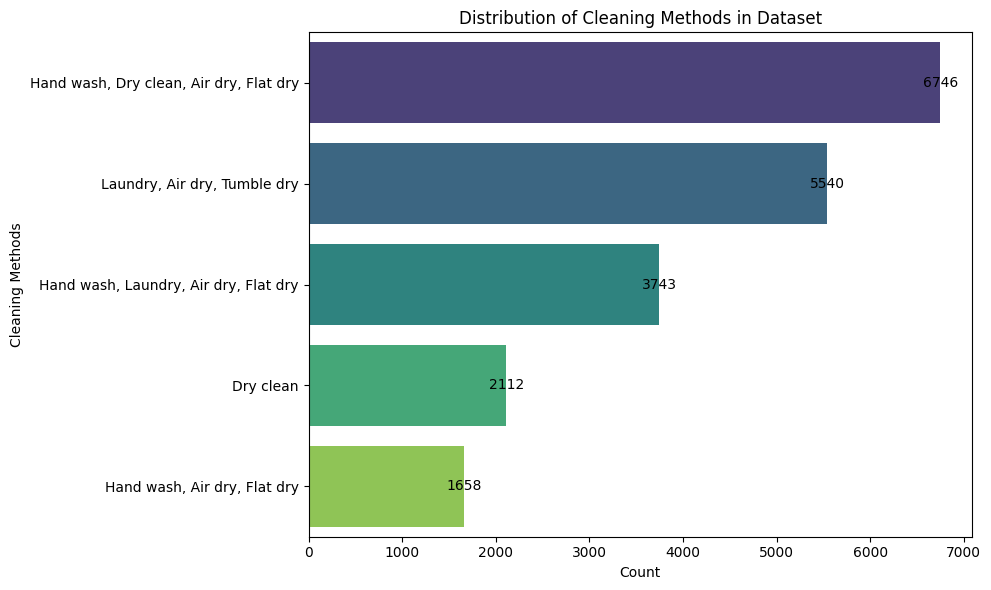

In [ ]:
# bar graph for every values in the combined labels

import matplotlib.pyplot as plt
import seaborn as sns

value_plot = df['Combined'].value_counts()

plt.figure(figsize=(10, 6))
barplot = sns.barplot(x=value_plot.values, y=value_plot.index, palette='viridis')

for p in barplot.patches:
    width = p.get_width()    
    plt.text(width + 5,      
             p.get_y() + p.get_height() / 2, 
             '{:1.0f}'.format(width), 
             ha = 'center',   
             va = 'center')   

plt.xlabel('Count')
plt.ylabel('Cleaning Methods')
plt.title('Distribution of Cleaning Methods in Dataset')
plt.tight_layout()
plt.show()


In [14]:
# balancing the dataset by using the lowest number of class, which is 1658
df = df.groupby('Combined').apply(lambda x: x.sample(n=1658, random_state=42)).reset_index(drop=True)

In [15]:
# print the new values after the balancing 
df['Combined'].value_counts()

Dry clean                                  1658
Hand wash, Air dry, Flat dry               1658
Hand wash, Dry clean, Air dry, Flat dry    1658
Hand wash, Laundry, Air dry, Flat dry      1658
Laundry, Air dry, Tumble dry               1658
Name: Combined, dtype: int64

In [16]:
df['Combined'].unique()

array(['Dry clean', 'Hand wash, Air dry, Flat dry',
       'Hand wash, Dry clean, Air dry, Flat dry',
       'Hand wash, Laundry, Air dry, Flat dry',
       'Laundry, Air dry, Tumble dry'], dtype=object)

In [17]:
# encoding the combined labels 
label_encoder = LabelEncoder()
df['Combined_Matrix'] = label_encoder.fit_transform(df['Combined'])

In [ ]:
# making a list to store the clothing images and labels
# resizing the images to 32x32
# skip images that cannto be loaded 
images = []
labels = []

for i, row in df.iterrows():
    try:
        image_path = os.path.join(dataset_directory, row['image_file'])
        image = Image.open(image_path)
        image = image.resize((32, 32))
        image = np.array(image) / 255.0

        image = np.expand_dims(image, axis=-1)  

        images.append(image)  
        labels.append(row['Combined_Matrix'])
    except IOError:
        print(f"Cannot load image at {image_path}. Skipping.")
        continue

Cannot load image at /content/drive/My Drive/image_aug/leather_jacket_282. Skipping.
Cannot load image at /content/drive/My Drive/image_aug/wool_sweater_395. Skipping.
Cannot load image at /content/drive/My Drive/image_aug/linen_dress_273. Skipping.
Cannot load image at /content/drive/My Drive/image_aug/rayon_skirt_273. Skipping.
Cannot load image at /content/drive/My Drive/image_aug/denim_jeans_245. Skipping.


In [19]:
print(images[0])

[[[[0.        ]
   [0.        ]
   [0.        ]]

  [[0.        ]
   [0.        ]
   [0.        ]]

  [[0.20784314]
   [0.20784314]
   [0.20784314]]

  ...

  [[0.        ]
   [0.        ]
   [0.        ]]

  [[0.        ]
   [0.        ]
   [0.        ]]

  [[0.        ]
   [0.        ]
   [0.        ]]]


 [[[0.        ]
   [0.        ]
   [0.        ]]

  [[0.        ]
   [0.        ]
   [0.        ]]

  [[0.4       ]
   [0.4       ]
   [0.4       ]]

  ...

  [[0.        ]
   [0.        ]
   [0.        ]]

  [[0.        ]
   [0.        ]
   [0.        ]]

  [[0.        ]
   [0.        ]
   [0.        ]]]


 [[[0.        ]
   [0.        ]
   [0.        ]]

  [[0.        ]
   [0.        ]
   [0.        ]]

  [[0.61960784]
   [0.61568627]
   [0.61568627]]

  ...

  [[0.        ]
   [0.        ]
   [0.        ]]

  [[0.        ]
   [0.        ]
   [0.        ]]

  [[0.        ]
   [0.        ]
   [0.        ]]]


 ...


 [[[0.88235294]
   [0.87843137]
   [0.8627451 ]]

  [[0.87843137]


In [20]:
# converting the images and labels to a numpy array 
images = np.array(images)
labels = np.array(labels)

In [21]:
print(labels)

[0 0 0 ... 4 4 4]


In [23]:
from tensorflow.keras.utils import to_categorical

# converting the labels to one-hot encoding
labels = to_categorical(labels)

In [24]:
# splitting the datasets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42, stratify = labels)

In [25]:
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

6628
6628
1657
1657


In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    # First Convolutional Layer with relu ac func
    Conv2D(16, (5, 5), activation='relu', strides=2, padding='same', input_shape=(32, 32, 3)),
    MaxPooling2D(pool_size=(2, 2), padding='same'),

    # Second Convolutional Layer 
    Conv2D(32, (3, 3), activation='relu', strides=1, padding='valid'),
    MaxPooling2D(pool_size=(2, 2), padding='valid'),
    Dropout(0.3),

    # Third Convolutional Layer
    Conv2D(32, (3, 3), activation='relu', strides=1, padding='same'),
    MaxPooling2D(pool_size=(2, 2), padding='valid'),

    # Flatten and Dense Layers
    Flatten(),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),

    # Output Layer
    Dense(5, activation='softmax') # 5 classes denoted by the 5 labels
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 16)        1216      
                                                                 
 max_pooling2d (MaxPooling2  (None, 8, 8, 16)          0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 6, 6, 32)          4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 3, 3, 32)          0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 3, 3, 32)          0         
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 32)          9

In [27]:
from tensorflow.keras.optimizers import Adam

# compiling the model and setting the accuracy as metrics 
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

In [28]:
# training the model
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=80)

Epoch 1/80
208/208 [==============================] - 6s 21ms/step - loss: 1.5426 - accuracy: 0.2876 - val_loss: 1.4431 - val_accuracy: 0.3506
Epoch 2/80
208/208 [==============================] - 4s 21ms/step - loss: 1.4167 - accuracy: 0.3823 - val_loss: 1.3453 - val_accuracy: 0.4267
Epoch 3/80
208/208 [==============================] - 3s 14ms/step - loss: 1.3474 - accuracy: 0.4354 - val_loss: 1.2889 - val_accuracy: 0.4466
Epoch 4/80
208/208 [==============================] - 3s 15ms/step - loss: 1.3000 - accuracy: 0.4578 - val_loss: 1.2646 - val_accuracy: 0.4659
Epoch 5/80
208/208 [==============================] - 3s 14ms/step - loss: 1.2699 - accuracy: 0.4677 - val_loss: 1.2453 - val_accuracy: 0.4665
Epoch 6/80
208/208 [==============================] - 4s 20ms/step - loss: 1.2335 - accuracy: 0.4894 - val_loss: 1.1746 - val_accuracy: 0.5190
Epoch 7/80
208/208 [==============================] - 4s 20ms/step - loss: 1.1822 - accuracy: 0.5100 - val_loss: 1.1307 - val_accuracy: 0.5347

In [29]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
class_report = classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print(class_report)

52/52 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

           0       0.81      0.63      0.71       332
           1       0.78      0.87      0.82       332
           2       0.46      0.37      0.41       331
           3       0.60      0.77      0.67       331
           4       0.56      0.59      0.57       331

    accuracy                           0.64      1657
   macro avg       0.64      0.64      0.64      1657
weighted avg       0.64      0.64      0.64      1657



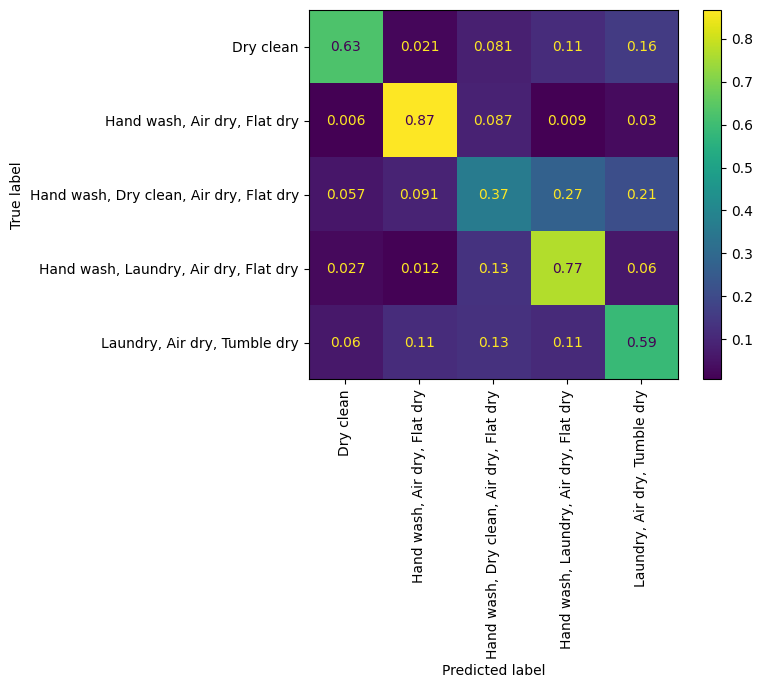

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

cm_label = ['Dry clean', 'Hand wash, Air dry, Flat dry',
            'Hand wash, Dry clean, Air dry, Flat dry',
            'Hand wash, Laundry, Air dry, Flat dry',
            'Laundry, Air dry, Tumble dry'] # labels

preds = [] # prediction list
true = [] # true list

for i in y_pred:
    preds.append(cm_label[np.argmax(i)]) # append labels

for i in y_test:
    true.append(cm_label[np.argmax(i)])  # append labels

confusion = confusion_matrix(true, preds, labels=cm_label) # make the confusion matrix

confusion_normalized = confusion.astype('float') / confusion.sum(axis=1)[:, np.newaxis] # normalize the confusion matrix

display = ConfusionMatrixDisplay(confusion_normalized, display_labels=cm_label) # display the confusion matrix

display.plot(xticks_rotation='vertical')  # make the x label vertical
plt.show() # show the confusion matrix

In [32]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle

In [33]:
n_classes = len(cm_label)

y_test_bin = label_binarize(y_test, classes=cm_label)
y_pred_bin = model.predict(X_test)

52/52 [==============================] - 0s 5ms/step


In [34]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [35]:
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_bin.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

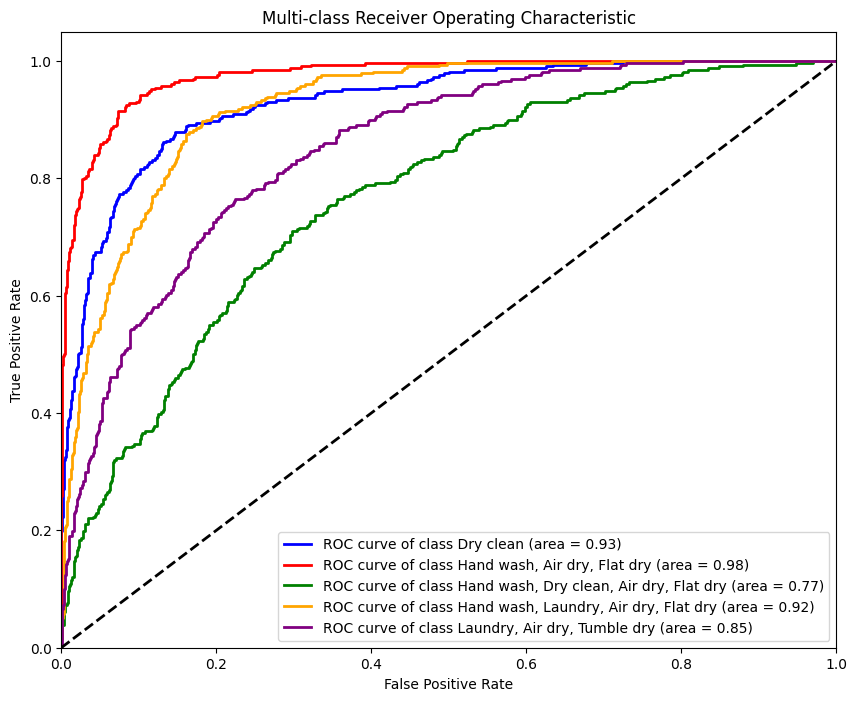

In [36]:
plt.figure(figsize=(10, 8))
lw = 2
colors = cycle(['blue', 'red', 'green', 'orange', 'purple'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(cm_label[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import numpy as np
from tqdm import tqdm

# create array of flattened image
images_flattened = [img.flatten() for img in tqdm(images, desc="Flattening images")]

# image flat arrat
images_flattened = np.array(images_flattened)

# labels 
labels_1d = np.argmax(labels, axis=1)

# split
X_train_ml, X_test_ml, y_train_ml, y_test_ml = train_test_split(images_flattened, labels_1d, test_size=0.2, random_state=42)

# init model
svm_model = SVC(kernel='rbf')  

# train
for i in tqdm(range(1), desc="Training model"):
  svm_model.fit(X_train_ml, y_train_ml)

# get preds
y_pred_ml = svm_model.predict(X_test_ml)

# calc acc
accuracy = accuracy_score(y_test_ml, y_pred_ml)
print(f"Baseline SVM Model Accuracy: {accuracy}")


Training model: 100%|██████████| 1/1 [02:42<00:00, 162.03s/it]


Baseline SVM Model Accuracy: 0.4888352444176222


In [38]:
print(classification_report(y_test_ml, y_pred_ml))
print(confusion_matrix(y_test_ml, y_pred_ml))


              precision    recall  f1-score   support

           0       0.48      0.51      0.49       349
           1       0.56      0.64      0.60       330
           2       0.38      0.28      0.32       335
           3       0.56      0.63      0.60       322
           4       0.41      0.39      0.40       321

    accuracy                           0.49      1657
   macro avg       0.48      0.49      0.48      1657
weighted avg       0.48      0.49      0.48      1657

[[178  69  23  31  48]
 [ 45 212  33  11  29]
 [ 50  45  93  74  73]
 [ 35  13  44 203  27]
 [ 63  39  54  41 124]]


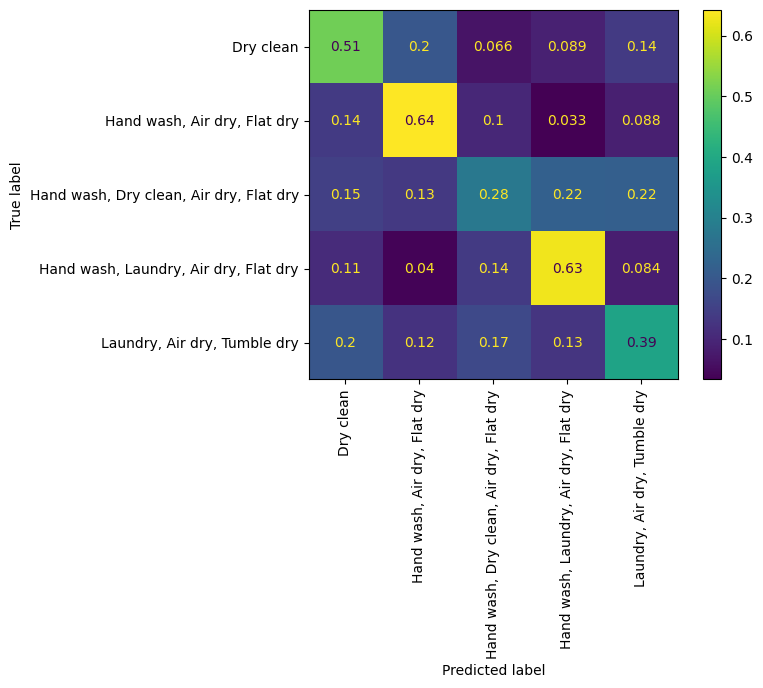

In [42]:
cm_label = ['Dry clean', 'Hand wash, Air dry, Flat dry',
            'Hand wash, Dry clean, Air dry, Flat dry',
            'Hand wash, Laundry, Air dry, Flat dry',
            'Laundry, Air dry, Tumble dry']

preds_ml = [cm_label[idx] for idx in y_pred_ml]
true_ml = [cm_label[idx] for idx in y_test_ml]

confusion = confusion_matrix(true_ml, preds_ml, labels=cm_label)

confusion_normalized = confusion.astype('float') / confusion.sum(axis=1)[:, np.newaxis]

display = ConfusionMatrixDisplay(confusion_normalized, display_labels=cm_label)
display.plot(xticks_rotation='vertical')  
plt.show()